In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
	Conv2D,
	MaxPooling2D,
	AveragePooling2D,
	Flatten,
    Input,
	Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

/Users/alexanderhsu/Documents/GitHub/ICSE_2025/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Consruct emotion model, download and load weights (Emotion.py in Deepface)

In [3]:
input_dim_ = 64
num_classes = 2
label_names = ['Not Confused', 'Confused']

In [4]:
files = ['../data_features_labels/EA_annotated_3Blue1Brown_final.pkl']
x_all_list_ea = []
y_all_list_ea = [] 
for file in files:
    with open(file, 'rb') as f:
        features, labels = pickle.load(f)
    for pic, label in zip(features, labels):
        x_all_list_ea.append(pic)
        y_all_list_ea.append(label)
X_all_ea = np.array(x_all_list_ea).reshape(-1, 64, 64, 1)
Y_all_ea = to_categorical(np.array(y_all_list_ea))

files = ['../data_features_labels/Polish_Dataset.pkl']
x_all_list_po = []
y_all_list_po = [] 
for file in files:
    with open(file, 'rb') as f:
        features, labels = pickle.load(f)
    for pic, label in zip(features, labels):
        x_all_list_po.append(pic)
        y_all_list_po.append(label)
X_all_po = np.array(x_all_list_po).reshape(-1, 64, 64, 1)
Y_all_po = to_categorical(np.array(y_all_list_po))


files = ['../data_features_labels/Train_crop.pkl', '../data_features_labels/Test_crop.pkl', '../data_features_labels/Validation_crop.pkl']
x_all_list_indian = []
y_all_list_indian = [] 
for file in files:
    with open(file, 'rb') as f:
        features, labels = pickle.load(f)
    for pic, label in zip(features, labels):
        x_all_list_indian.append(pic)
        y_all_list_indian.append(label)
X_all_indian = np.array(x_all_list_indian).reshape(-1, 64, 64, 1)
Y_all_indian = to_categorical(np.array(y_all_list_indian))


In [15]:
accuracy_ea_list = []
accuracy_po_list = []
accuracy_indian_list = []


for seed in np.arange(2024, 2034):
    model = Sequential()
    model.add(Input(shape=(64, 64, 1)))
    model.add(Conv2D(64, (5, 5), activation="relu"))
    model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.load_weights(f'../models/asian_confusion_weights_final_{seed}.h5')
    
    # Evaluate on EA dataset
    x_train_ea, x_test_ea, y_train_ea, y_test_ea = train_test_split(X_all_ea, Y_all_ea, test_size=0.2, random_state=seed)
    prediction_proba_ea = model.predict(x_test_ea, verbose=0)
    y_predict_ea = prediction_proba_ea.argmax(axis=1)
    y_true_ea = y_test_ea.argmax(axis=1)
    accuracy_ea = accuracy_score(y_true_ea, y_predict_ea)
    accuracy_ea_list.append(accuracy_ea)
    
    # Evaluate on PO dataset
    x_train_po, x_test_po, y_train_po, y_test_po = train_test_split(X_all_po, Y_all_po, test_size=0.2, random_state=seed)
    prediction_proba_po = model.predict(x_test_po, verbose=0)
    y_predict_po = prediction_proba_po.argmax(axis=1)
    y_true_po = y_test_po.argmax(axis=1)
    accuracy_po = accuracy_score(y_true_po, y_predict_po)
    accuracy_po_list.append(accuracy_po)
    
    # Evaluate on Indian dataset
    x_train_indian, x_test_indian, y_train_indian, y_test_indian = train_test_split(X_all_indian, Y_all_indian, test_size=0.2, random_state=seed)
    prediction_proba_indian = model.predict(x_test_indian, verbose=0)
    y_predict_indian = prediction_proba_indian.argmax(axis=1)
    y_true_indian = y_test_indian.argmax(axis=1)
    accuracy_indian = accuracy_score(y_true_indian, y_predict_indian)
    accuracy_indian_list.append(accuracy_indian)

In [16]:
# Calculate mean and standard deviation for error bars
mean_accuracies = [np.mean(accuracy_ea_list), np.mean(accuracy_po_list), np.mean(accuracy_indian_list)]
std_accuracies = [np.std(accuracy_ea_list), np.std(accuracy_po_list), np.std(accuracy_indian_list)]

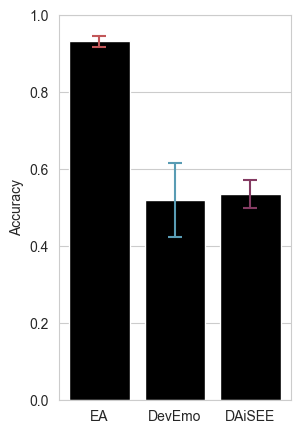

In [18]:
# Define colors for each group
colors = ['#C25759', '#599CB4', '#843b62']  # EA, Polish (PO), Indian

# Plot with error bars
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.barplot(x=['EA', 'DevEmo', 'DAiSEE'], y=mean_accuracies, color='k', ax=ax)

# Add error bars manually
for i, (mean, std, color) in enumerate(zip(mean_accuracies, std_accuracies, colors)):
    ax.errorbar(i, mean, yerr=std, fmt='none', capsize=5, capthick=1.5, color=color)

ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1])
fig.savefig('../figure_panels/EAmodel_testonALL_CV.svg', bbox_inches='tight', dpi=300)
plt.show()